In [672]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [673]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [707]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:8]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        #layers.Dropout(0.3),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.055
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #base_learning_rate = 0.01
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [708]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [709]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [710]:
batch_size=256

In [711]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [712]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [713]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [714]:
prediction_result_cv = []
prediction_result_ind = []

In [715]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all')

In [716]:
out = os.getcwd() + '\\'

In [717]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0 

8/8 - 0s - loss: 0.5423 - accuracy: 0.7138 - val_loss: 0.5891 - val_accuracy: 0.6889

Epoch 00035: val_loss did not improve from 0.57889
Epoch 36/300
8/8 - 0s - loss: 0.5490 - accuracy: 0.7133 - val_loss: 0.5888 - val_accuracy: 0.6711

Epoch 00036: val_loss did not improve from 0.57889
Epoch 37/300
8/8 - 0s - loss: 0.5391 - accuracy: 0.7143 - val_loss: 0.5859 - val_accuracy: 0.6800

Epoch 00037: val_loss did not improve from 0.57889
Epoch 38/300
8/8 - 0s - loss: 0.5566 - accuracy: 0.7084 - val_loss: 0.5876 - val_accuracy: 0.6889

Epoch 00038: val_loss did not improve from 0.57889
Epoch 39/300
8/8 - 0s - loss: 0.5601 - accuracy: 0.7054 - val_loss: 0.6032 - val_accuracy: 0.6756

Epoch 00039: val_loss did not improve from 0.57889
Epoch 40/300
8/8 - 0s - loss: 0.5407 - accuracy: 0.7163 - val_loss: 0.5957 - val_accuracy: 0.6711

Epoch 00040: val_loss did not improve from 0.57889
Epoch 41/300
8/8 - 0s - loss: 0.5610 - accuracy: 0.7118 - val_loss: 0.5962 - val_accuracy: 0.6756

Epoch 00041: v

8/8 - 1s - loss: 1.1303 - accuracy: 0.6273 - val_loss: 0.6049 - val_accuracy: 0.6622

Epoch 00001: val_loss improved from inf to 0.60488, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.5660 - accuracy: 0.7039 - val_loss: 0.5990 - val_accuracy: 0.6889

Epoch 00002: val_loss improved from 0.60488 to 0.59898, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_1.h5
Epoch 3/300
8/8 - 0s - loss: 0.5795 - accuracy: 0.6826 - val_loss: 0.6033 - val_accuracy: 0.7244

Epoch 00003: val_loss did not improve from 0.59898
Epoch 4/300
8/8 - 0s - loss: 0.5609 - accuracy: 0.6995 - val_loss: 0.5890 - val_accuracy: 0.6711

Epoch 00004: val_loss improved from 0.59898 to 0.58903, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_1.h5
Epoch 5/300
8/8 - 0s 


Epoch 00049: val_loss did not improve from 0.57656
Epoch 50/300
8/8 - 0s - loss: 0.5417 - accuracy: 0.7123 - val_loss: 0.5905 - val_accuracy: 0.7378

Epoch 00050: val_loss did not improve from 0.57656
Epoch 51/300
8/8 - 0s - loss: 0.5364 - accuracy: 0.7281 - val_loss: 0.5996 - val_accuracy: 0.6933

Epoch 00051: val_loss did not improve from 0.57656
Epoch 52/300
8/8 - 0s - loss: 0.5520 - accuracy: 0.7118 - val_loss: 0.5929 - val_accuracy: 0.7022

Epoch 00052: val_loss did not improve from 0.57656
Epoch 53/300
8/8 - 0s - loss: 0.5399 - accuracy: 0.7168 - val_loss: 0.6000 - val_accuracy: 0.6933

Epoch 00053: val_loss did not improve from 0.57656
Epoch 54/300
8/8 - 0s - loss: 0.5477 - accuracy: 0.7133 - val_loss: 0.5921 - val_accuracy: 0.7156

Epoch 00054: val_loss did not improve from 0.57656
Epoch 55/300
8/8 - 0s - loss: 0.5433 - accuracy: 0.7242 - val_loss: 0.6005 - val_accuracy: 0.7022

Epoch 00055: val_loss did not improve from 0.57656
Epoch 56/300
8/8 - 0s - loss: 0.5494 - accuracy:

8/8 - 1s - loss: 1.1904 - accuracy: 0.6085 - val_loss: 0.5942 - val_accuracy: 0.6622

Epoch 00001: val_loss improved from inf to 0.59421, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_2.h5
Epoch 2/300
8/8 - 0s - loss: 0.5743 - accuracy: 0.7019 - val_loss: 0.5855 - val_accuracy: 0.6622

Epoch 00002: val_loss improved from 0.59421 to 0.58554, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_2.h5
Epoch 3/300
8/8 - 0s - loss: 0.5688 - accuracy: 0.7004 - val_loss: 0.5901 - val_accuracy: 0.6756

Epoch 00003: val_loss did not improve from 0.58554
Epoch 4/300
8/8 - 0s - loss: 0.5681 - accuracy: 0.7054 - val_loss: 0.5857 - val_accuracy: 0.6622

Epoch 00004: val_loss did not improve from 0.58554
Epoch 5/300
8/8 - 0s - loss: 0.5729 - accuracy: 0.7029 - val_loss: 0.5974 - val_accuracy: 0.6756

Epoch 00005: val_loss did not improve from 0.58554
Epoch


Epoch 00050: val_loss did not improve from 0.57952
Epoch 51/300
8/8 - 0s - loss: 0.5311 - accuracy: 0.7321 - val_loss: 0.6018 - val_accuracy: 0.6667

Epoch 00051: val_loss did not improve from 0.57952
Epoch 52/300
8/8 - 0s - loss: 0.5414 - accuracy: 0.7217 - val_loss: 0.5895 - val_accuracy: 0.6889

Epoch 00052: val_loss did not improve from 0.57952
Epoch 53/300
8/8 - 0s - loss: 0.5357 - accuracy: 0.7306 - val_loss: 0.6061 - val_accuracy: 0.6667

Epoch 00053: val_loss did not improve from 0.57952
Epoch 54/300
8/8 - 0s - loss: 0.5603 - accuracy: 0.7133 - val_loss: 0.5975 - val_accuracy: 0.6800

Epoch 00054: val_loss did not improve from 0.57952
Epoch 55/300
8/8 - 0s - loss: 0.5359 - accuracy: 0.7163 - val_loss: 0.5895 - val_accuracy: 0.6711

Epoch 00055: val_loss did not improve from 0.57952
Epoch 56/300
8/8 - 0s - loss: 0.5443 - accuracy: 0.7187 - val_loss: 0.6048 - val_accuracy: 0.6756

Epoch 00056: val_loss did not improve from 0.57952
Epoch 57/300
8/8 - 0s - loss: 0.5522 - accuracy:

8/8 - 1s - loss: 0.9642 - accuracy: 0.6209 - val_loss: 0.5777 - val_accuracy: 0.7644

Epoch 00001: val_loss improved from inf to 0.57771, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_3.h5
Epoch 2/300
8/8 - 0s - loss: 0.5947 - accuracy: 0.6767 - val_loss: 0.5557 - val_accuracy: 0.7778

Epoch 00002: val_loss improved from 0.57771 to 0.55567, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_3.h5
Epoch 3/300
8/8 - 0s - loss: 0.5770 - accuracy: 0.6881 - val_loss: 0.5534 - val_accuracy: 0.7378

Epoch 00003: val_loss improved from 0.55567 to 0.55337, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_3.h5
Epoch 4/300
8/8 - 0s - loss: 0.5811 - accuracy: 0.6920 - val_loss: 0.5415 - val_accuracy: 0.7467

Epoch 00004: val_loss improved from 0.55337 to 0.54147, saving model to 


Epoch 00049: val_loss did not improve from 0.51411
Epoch 50/300
8/8 - 0s - loss: 0.5597 - accuracy: 0.7059 - val_loss: 0.5675 - val_accuracy: 0.7689

Epoch 00050: val_loss did not improve from 0.51411
Epoch 51/300
8/8 - 0s - loss: 0.5550 - accuracy: 0.7024 - val_loss: 0.5554 - val_accuracy: 0.7644

Epoch 00051: val_loss did not improve from 0.51411
Epoch 52/300
8/8 - 0s - loss: 0.5409 - accuracy: 0.7276 - val_loss: 0.5403 - val_accuracy: 0.7822

Epoch 00052: val_loss did not improve from 0.51411
Epoch 53/300
8/8 - 0s - loss: 0.5582 - accuracy: 0.7143 - val_loss: 0.5749 - val_accuracy: 0.7111

Epoch 00053: val_loss did not improve from 0.51411
Epoch 54/300
8/8 - 0s - loss: 0.5535 - accuracy: 0.7153 - val_loss: 0.5494 - val_accuracy: 0.7867

Epoch 00054: val_loss did not improve from 0.51411
Epoch 55/300
8/8 - 0s - loss: 0.5625 - accuracy: 0.7054 - val_loss: 0.5482 - val_accuracy: 0.7956

Epoch 00055: val_loss did not improve from 0.51411
Epoch 56/300
8/8 - 0s - loss: 0.5603 - accuracy:


Epoch 00014: val_loss did not improve from 0.56572
Epoch 15/300
8/8 - 0s - loss: 0.5534 - accuracy: 0.7242 - val_loss: 0.5826 - val_accuracy: 0.7111

Epoch 00015: val_loss did not improve from 0.56572
Epoch 16/300
8/8 - 0s - loss: 0.5540 - accuracy: 0.7039 - val_loss: 0.5852 - val_accuracy: 0.6978

Epoch 00016: val_loss did not improve from 0.56572
Epoch 17/300
8/8 - 0s - loss: 0.5571 - accuracy: 0.7237 - val_loss: 0.5777 - val_accuracy: 0.6978

Epoch 00017: val_loss did not improve from 0.56572
Epoch 18/300
8/8 - 0s - loss: 0.5861 - accuracy: 0.6970 - val_loss: 0.5805 - val_accuracy: 0.6978

Epoch 00018: val_loss did not improve from 0.56572
Epoch 19/300
8/8 - 0s - loss: 0.5459 - accuracy: 0.7118 - val_loss: 0.5782 - val_accuracy: 0.6933

Epoch 00019: val_loss did not improve from 0.56572
Epoch 20/300
8/8 - 0s - loss: 0.5610 - accuracy: 0.7079 - val_loss: 0.5979 - val_accuracy: 0.6711

Epoch 00020: val_loss did not improve from 0.56572
Epoch 21/300
8/8 - 0s - loss: 0.5473 - accuracy:

Model: "sequential_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_265 (Functional)       (None, 5, 128)            199680    
_________________________________________________________________
dense_530 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
global_average_pooling1d_265 (None, 64)                0         
_________________________________________________________________
dense_531 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 8,321
Non-trainable params: 199,680
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 1.0955 - accuracy: 0.6095 - val_loss: 0.5856 - val_accuracy: 0.7200

Epoch 00001: val_loss improved from inf to 0.58562, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model


Epoch 00043: val_loss did not improve from 0.54194
Epoch 44/300
8/8 - 0s - loss: 0.5574 - accuracy: 0.7029 - val_loss: 0.5598 - val_accuracy: 0.7556

Epoch 00044: val_loss did not improve from 0.54194
Epoch 45/300
8/8 - 0s - loss: 0.5580 - accuracy: 0.7103 - val_loss: 0.5423 - val_accuracy: 0.7556

Epoch 00045: val_loss did not improve from 0.54194
Epoch 46/300
8/8 - 0s - loss: 0.5498 - accuracy: 0.7182 - val_loss: 0.5513 - val_accuracy: 0.7422

Epoch 00046: val_loss did not improve from 0.54194
Epoch 47/300
8/8 - 0s - loss: 0.5409 - accuracy: 0.7227 - val_loss: 0.5480 - val_accuracy: 0.7333

Epoch 00047: val_loss did not improve from 0.54194
Epoch 48/300
8/8 - 0s - loss: 0.5462 - accuracy: 0.7212 - val_loss: 0.5521 - val_accuracy: 0.7422

Epoch 00048: val_loss did not improve from 0.54194
Epoch 49/300
8/8 - 0s - loss: 0.5516 - accuracy: 0.7197 - val_loss: 0.5702 - val_accuracy: 0.7200

Epoch 00049: val_loss did not improve from 0.54194
Epoch 50/300
8/8 - 0s - loss: 0.5431 - accuracy:

Model: "sequential_266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_266 (Functional)       (None, 5, 128)            199680    
_________________________________________________________________
dense_532 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
global_average_pooling1d_266 (None, 64)                0         
_________________________________________________________________
dense_533 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 8,321
Non-trainable params: 199,680
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.9607 - accuracy: 0.6021 - val_loss: 0.6099 - val_accuracy: 0.6756

Epoch 00001: val_loss improved from inf to 0.60986, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model


Epoch 00045: val_loss did not improve from 0.56999
Epoch 46/300
8/8 - 0s - loss: 0.5609 - accuracy: 0.7138 - val_loss: 0.5876 - val_accuracy: 0.7067

Epoch 00046: val_loss did not improve from 0.56999
Epoch 47/300
8/8 - 0s - loss: 0.5448 - accuracy: 0.7247 - val_loss: 0.5851 - val_accuracy: 0.6978

Epoch 00047: val_loss did not improve from 0.56999
Epoch 48/300
8/8 - 0s - loss: 0.5318 - accuracy: 0.7257 - val_loss: 0.5740 - val_accuracy: 0.7200

Epoch 00048: val_loss did not improve from 0.56999
Epoch 49/300
8/8 - 0s - loss: 0.5671 - accuracy: 0.7044 - val_loss: 0.5949 - val_accuracy: 0.6756

Epoch 00049: val_loss did not improve from 0.56999
Epoch 50/300
8/8 - 0s - loss: 0.5618 - accuracy: 0.7014 - val_loss: 0.6002 - val_accuracy: 0.6800

Epoch 00050: val_loss did not improve from 0.56999
Epoch 51/300
8/8 - 0s - loss: 0.5210 - accuracy: 0.7360 - val_loss: 0.5829 - val_accuracy: 0.6978

Epoch 00051: val_loss did not improve from 0.56999
Epoch 52/300
8/8 - 0s - loss: 0.5425 - accuracy:


Epoch 00004: val_loss improved from 0.57300 to 0.55766, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.5690 - accuracy: 0.7163 - val_loss: 0.5503 - val_accuracy: 0.7333

Epoch 00005: val_loss improved from 0.55766 to 0.55033, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\_7.h5
Epoch 6/300
8/8 - 0s - loss: 0.5907 - accuracy: 0.6906 - val_loss: 0.5748 - val_accuracy: 0.7289

Epoch 00006: val_loss did not improve from 0.55033
Epoch 7/300
8/8 - 0s - loss: 0.5802 - accuracy: 0.7049 - val_loss: 0.5763 - val_accuracy: 0.7200

Epoch 00007: val_loss did not improve from 0.55033
Epoch 8/300
8/8 - 0s - loss: 0.5816 - accuracy: 0.6906 - val_loss: 0.5426 - val_accuracy: 0.7644

Epoch 00008: val_loss improved from 0.55033 to 0.54258, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\tar

8/8 - 0s - loss: 0.5609 - accuracy: 0.7113 - val_loss: 0.5607 - val_accuracy: 0.7378

Epoch 00056: val_loss did not improve from 0.53761
Epoch 57/300
8/8 - 0s - loss: 0.5550 - accuracy: 0.7177 - val_loss: 0.5572 - val_accuracy: 0.7244

Epoch 00057: val_loss did not improve from 0.53761
Epoch 58/300
8/8 - 0s - loss: 0.5515 - accuracy: 0.7148 - val_loss: 0.5703 - val_accuracy: 0.7111

Epoch 00058: val_loss did not improve from 0.53761
Epoch 59/300
8/8 - 0s - loss: 0.5500 - accuracy: 0.7182 - val_loss: 0.5557 - val_accuracy: 0.7289

Epoch 00059: val_loss did not improve from 0.53761
Epoch 60/300
8/8 - 0s - loss: 0.5557 - accuracy: 0.7049 - val_loss: 0.5706 - val_accuracy: 0.7333

Epoch 00060: val_loss did not improve from 0.53761
Epoch 61/300
8/8 - 0s - loss: 0.5399 - accuracy: 0.7153 - val_loss: 0.5726 - val_accuracy: 0.7022

Epoch 00061: val_loss did not improve from 0.53761
Epoch 62/300
8/8 - 0s - loss: 0.5471 - accuracy: 0.7123 - val_loss: 0.5581 - val_accuracy: 0.7244

Epoch 00062: v

8/8 - 0s - loss: 0.5665 - accuracy: 0.6952 - val_loss: 0.5642 - val_accuracy: 0.7009

Epoch 00014: val_loss did not improve from 0.53828
Epoch 15/300
8/8 - 0s - loss: 0.5745 - accuracy: 0.6932 - val_loss: 0.5552 - val_accuracy: 0.7768

Epoch 00015: val_loss did not improve from 0.53828
Epoch 16/300
8/8 - 0s - loss: 0.5687 - accuracy: 0.6932 - val_loss: 0.5627 - val_accuracy: 0.7009

Epoch 00016: val_loss did not improve from 0.53828
Epoch 17/300
8/8 - 0s - loss: 0.5619 - accuracy: 0.7045 - val_loss: 0.5540 - val_accuracy: 0.7812

Epoch 00017: val_loss did not improve from 0.53828
Epoch 18/300
8/8 - 0s - loss: 0.5792 - accuracy: 0.6892 - val_loss: 0.5619 - val_accuracy: 0.6964

Epoch 00018: val_loss did not improve from 0.53828
Epoch 19/300
8/8 - 0s - loss: 0.5652 - accuracy: 0.7011 - val_loss: 0.5488 - val_accuracy: 0.7455

Epoch 00019: val_loss did not improve from 0.53828
Epoch 20/300
8/8 - 0s - loss: 0.5750 - accuracy: 0.6937 - val_loss: 0.5646 - val_accuracy: 0.7455

Epoch 00020: v

Model: "sequential_269"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_269 (Functional)       (None, 5, 128)            199680    
_________________________________________________________________
dense_538 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
global_average_pooling1d_269 (None, 64)                0         
_________________________________________________________________
dense_539 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 8,321
Non-trainable params: 199,680
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.9890 - accuracy: 0.6092 - val_loss: 0.5913 - val_accuracy: 0.6964

Epoch 00001: val_loss improved from inf to 0.59134, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model


Epoch 00047: val_loss did not improve from 0.56267
Epoch 48/300
8/8 - 0s - loss: 0.5473 - accuracy: 0.7204 - val_loss: 0.5906 - val_accuracy: 0.6830

Epoch 00048: val_loss did not improve from 0.56267
Epoch 49/300
8/8 - 0s - loss: 0.5345 - accuracy: 0.7263 - val_loss: 0.5810 - val_accuracy: 0.6964

Epoch 00049: val_loss did not improve from 0.56267
Epoch 50/300
8/8 - 0s - loss: 0.5403 - accuracy: 0.7258 - val_loss: 0.5829 - val_accuracy: 0.7054

Epoch 00050: val_loss did not improve from 0.56267
Epoch 51/300
8/8 - 0s - loss: 0.5392 - accuracy: 0.7248 - val_loss: 0.5817 - val_accuracy: 0.6920

Epoch 00051: val_loss did not improve from 0.56267
Epoch 52/300
8/8 - 0s - loss: 0.5477 - accuracy: 0.7273 - val_loss: 0.5862 - val_accuracy: 0.6741

Epoch 00052: val_loss did not improve from 0.56267
Epoch 53/300
8/8 - 0s - loss: 0.5512 - accuracy: 0.7149 - val_loss: 0.6068 - val_accuracy: 0.6473

Epoch 00053: val_loss did not improve from 0.56267
Epoch 54/300
8/8 - 0s - loss: 0.5578 - accuracy:

In [718]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [719]:
roc_auc_list_val

[0.7661188369152971,
 0.787627551020408,
 0.7884007585335019,
 0.7612989886219975,
 0.8644911504424779,
 0.787373577749684,
 0.8302781289506953,
 0.7764696586599241,
 0.8347029077117573,
 0.8406409438775512]

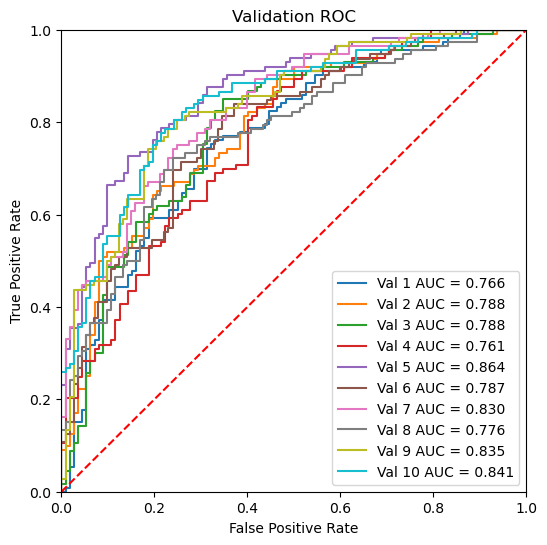

In [720]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

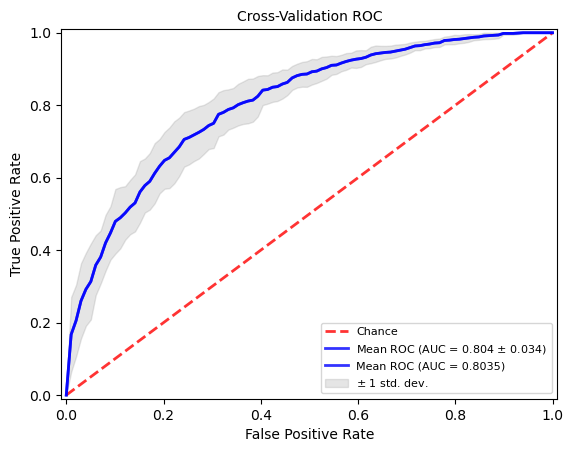

In [721]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [722]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [723]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [724]:
my_calculate_metrics_list_val

[{'SN': 0.7168141592920354,
  'SP': 0.6875,
  'ACC': 0.7022222222222222,
  'MCC': 0.4045059743542811,
  'Recall': 0.7168141592920354,
  'Precision': 0.6982758620689655,
  'F1-score': 0.7074235807860262,
  'Cutoff': 0.5},
 {'SN': 0.7767857142857143,
  'SP': 0.6160714285714286,
  'ACC': 0.6964285714285714,
  'MCC': 0.398031161138567,
  'Recall': 0.7767857142857143,
  'Precision': 0.6692307692307692,
  'F1-score': 0.71900826446281,
  'Cutoff': 0.5},
 {'SN': 0.6902654867256637,
  'SP': 0.6964285714285714,
  'ACC': 0.6933333333333334,
  'MCC': 0.38669405815423513,
  'Recall': 0.6902654867256637,
  'Precision': 0.6964285714285714,
  'F1-score': 0.6933333333333334,
  'Cutoff': 0.5},
 {'SN': 0.831858407079646,
  'SP': 0.5803571428571429,
  'ACC': 0.7066666666666667,
  'MCC': 0.4261116462750163,
  'Recall': 0.831858407079646,
  'Precision': 0.6666666666666666,
  'F1-score': 0.7401574803149606,
  'Cutoff': 0.5},
 {'SN': 0.7787610619469026,
  'SP': 0.7946428571428571,
  'ACC': 0.7866666666666666,

In [725]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.716814,0.687500,0.702222,0.404506,0.716814,0.698276,0.707424,0.5
1,0.776786,0.616071,0.696429,0.398031,0.776786,0.669231,0.719008,0.5
2,0.690265,0.696429,0.693333,0.386694,0.690265,0.696429,0.693333,0.5
3,0.831858,0.580357,0.706667,0.426112,0.831858,0.666667,0.740157,0.5
4,0.778761,0.794643,0.786667,0.573449,0.778761,0.792793,0.785714,0.5
5,0.857143,0.495575,0.675556,0.378063,0.857143,0.627451,0.724528,0.5
6,0.776786,0.690265,0.733333,0.468721,0.776786,0.713115,0.743590,0.5
7,0.821429,0.504425,0.662222,0.343395,0.821429,0.621622,0.707692,0.5
8,0.821429,0.646018,0.733333,0.474626,0.821429,0.696970,0.754098,0.5
9,0.678571,0.830357,0.754464,0.514894,0.678571,0.800000,0.734300,0.5


In [726]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.716814,0.687500,0.702222,0.404506,0.716814,0.698276,0.707424,0.5
1,0.776786,0.616071,0.696429,0.398031,0.776786,0.669231,0.719008,0.5
2,0.690265,0.696429,0.693333,0.386694,0.690265,0.696429,0.693333,0.5
3,0.831858,0.580357,0.706667,0.426112,0.831858,0.666667,0.740157,0.5
4,0.778761,0.794643,0.786667,0.573449,0.778761,0.792793,0.785714,0.5
5,0.857143,0.495575,0.675556,0.378063,0.857143,0.627451,0.724528,0.5
6,0.776786,0.690265,0.733333,0.468721,0.776786,0.713115,0.743590,0.5
7,0.821429,0.504425,0.662222,0.343395,0.821429,0.621622,0.707692,0.5
8,0.821429,0.646018,0.733333,0.474626,0.821429,0.696970,0.754098,0.5
9,0.678571,0.830357,0.754464,0.514894,0.678571,0.800000,0.734300,0.5


In [727]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [728]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [729]:
roc_auc_list_indep

[0.7975924744897959,
 0.7991071428571429,
 0.7849170918367346,
 0.7995057397959184,
 0.7948820153061226,
 0.7969547193877551,
 0.8265306122448979,
 0.8001434948979592,
 0.8055644132653061,
 0.79296875]

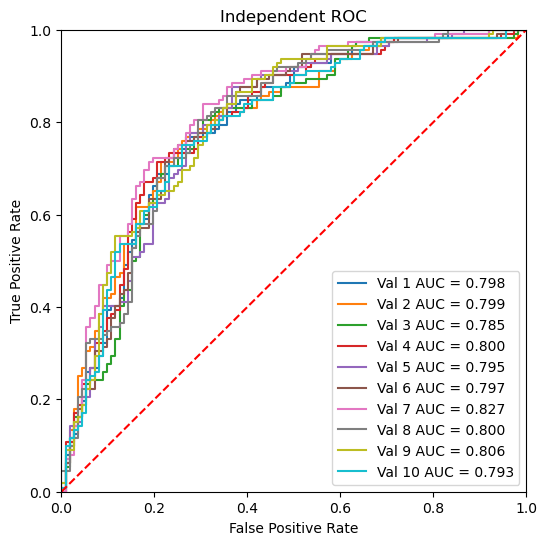

In [730]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

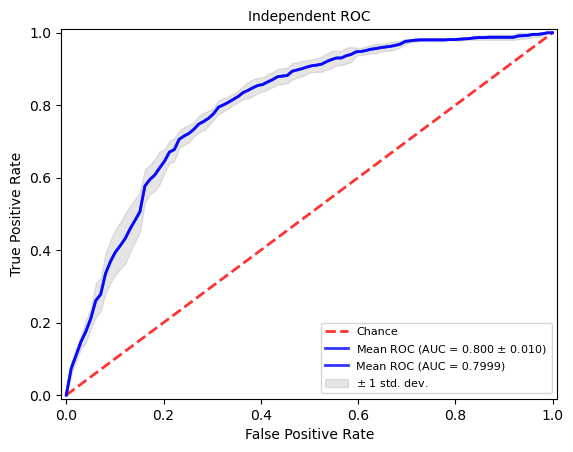

In [731]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [699]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [700]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [701]:
my_calculate_metrics_list_indep

[{'SN': 0.8392857142857143,
  'SP': 0.5892857142857143,
  'ACC': 0.7142857142857143,
  'MCC': 0.44262666813799045,
  'Recall': 0.8392857142857143,
  'Precision': 0.6714285714285714,
  'F1-score': 0.746031746031746,
  'Cutoff': 0.5},
 {'SN': 0.8928571428571429,
  'SP': 0.5535714285714286,
  'ACC': 0.7232142857142857,
  'MCC': 0.4745789978762495,
  'Recall': 0.8928571428571429,
  'Precision': 0.6666666666666666,
  'F1-score': 0.7633587786259542,
  'Cutoff': 0.5},
 {'SN': 0.8214285714285714,
  'SP': 0.6339285714285714,
  'ACC': 0.7276785714285714,
  'MCC': 0.4635788987394952,
  'Recall': 0.8214285714285714,
  'Precision': 0.6917293233082706,
  'F1-score': 0.7510204081632653,
  'Cutoff': 0.5},
 {'SN': 0.8839285714285714,
  'SP': 0.5803571428571429,
  'ACC': 0.7321428571428571,
  'MCC': 0.4872811533133918,
  'Recall': 0.8839285714285714,
  'Precision': 0.678082191780822,
  'F1-score': 0.7674418604651163,
  'Cutoff': 0.5},
 {'SN': 0.8839285714285714,
  'SP': 0.5714285714285714,
  'ACC': 0.72

In [702]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.839286,0.589286,0.714286,0.442627,0.839286,0.671429,0.746032,0.5
1,0.892857,0.553571,0.723214,0.474579,0.892857,0.666667,0.763359,0.5
2,0.821429,0.633929,0.727679,0.463579,0.821429,0.691729,0.751020,0.5
3,0.883929,0.580357,0.732143,0.487281,0.883929,0.678082,0.767442,0.5
4,0.883929,0.571429,0.727679,0.479365,0.883929,0.673469,0.764479,0.5
5,0.857143,0.571429,0.714286,0.447214,0.857143,0.666667,0.750000,0.5
6,0.776786,0.660714,0.718750,0.440477,0.776786,0.696000,0.734177,0.5
7,0.803571,0.705357,0.754464,0.511401,0.803571,0.731707,0.765957,0.5
8,0.875000,0.553571,0.714286,0.452589,0.875000,0.662162,0.753846,0.5
9,0.678571,0.750000,0.714286,0.429669,0.678571,0.730769,0.703704,0.5


In [703]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.839286,0.589286,0.714286,0.442627,0.839286,0.671429,0.746032,0.5
1,0.892857,0.553571,0.723214,0.474579,0.892857,0.666667,0.763359,0.5
2,0.821429,0.633929,0.727679,0.463579,0.821429,0.691729,0.751020,0.5
3,0.883929,0.580357,0.732143,0.487281,0.883929,0.678082,0.767442,0.5
4,0.883929,0.571429,0.727679,0.479365,0.883929,0.673469,0.764479,0.5
5,0.857143,0.571429,0.714286,0.447214,0.857143,0.666667,0.750000,0.5
6,0.776786,0.660714,0.718750,0.440477,0.776786,0.696000,0.734177,0.5
7,0.803571,0.705357,0.754464,0.511401,0.803571,0.731707,0.765957,0.5
8,0.875000,0.553571,0.714286,0.452589,0.875000,0.662162,0.753846,0.5
9,0.678571,0.750000,0.714286,0.429669,0.678571,0.730769,0.703704,0.5


In [704]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K\freeze_all\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [705]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

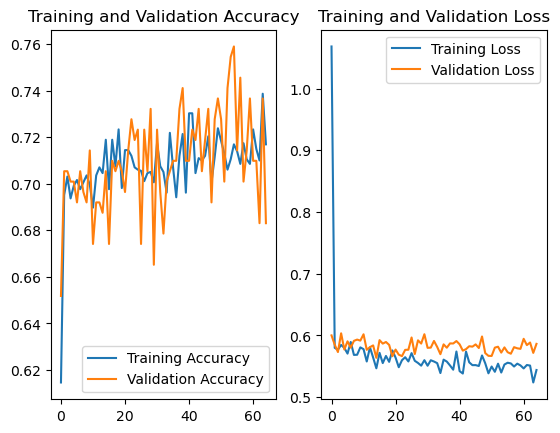

In [706]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()